## Load-In

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.optim import AdamW
pd.options.mode.chained_assignment = None
import warnings
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN

from google.colab import drive
drive.mount('/content/drive')

games = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/games.csv")
player_play = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/player_play.csv")
players = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/players.csv")
plays = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/plays.csv")

players_tells = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/players_tells_tracking.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# takes roughly ~5mins to run
# -- loading in tracking data with zone/man probs

all_data = []

for week_eval in range(1,10):

  preds_week = pd.read_csv(f"/content/drive/MyDrive/nfl-big-data-bowl-2025/tracking_week_{week_eval}_preds.csv")
  all_data.append(preds_week)
  print(f"Finished processing week {week_eval}...")

all_weeks = pd.concat(all_data, ignore_index=True)
all_weeks['base_correct'] = all_weeks['pred'] == all_weeks['actual']

Finished processing week 1...
Finished processing week 2...
Finished processing week 3...
Finished processing week 4...
Finished processing week 5...
Finished processing week 6...
Finished processing week 7...
Finished processing week 8...
Finished processing week 9...


In [ ]:
# -- reading in original data (lost the LOS start & good to have all data)

# reading static CSV files (currently in GDrive)
games = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/games.csv")
player_play = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/player_play.csv")
players = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/players.csv")
plays = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/plays.csv")

weeks_comp = []

for week_number in range(1, 10):
  week_data = process_week_data(week_number, plays)
  weeks_comp.append(week_data)

all_tracking = pd.concat(weeks_comp, ignore_index=True)
all_tracking = all_tracking[(all_tracking['passAttempt'] == 1)]

Finished reading Week 1 data
Finished processing Week 1 data

Finished reading Week 2 data
Finished processing Week 2 data

Finished reading Week 3 data
Finished processing Week 3 data

Finished reading Week 4 data
Finished processing Week 4 data

Finished reading Week 5 data
Finished processing Week 5 data

Finished reading Week 6 data
Finished processing Week 6 data

Finished reading Week 7 data
Finished processing Week 7 data

Finished reading Week 8 data
Finished processing Week 8 data

Finished reading Week 9 data
Finished processing Week 9 data



## Prepping Data

In [ ]:
# standardizing so all plays start at 25

def start_at_25(all_tracking):

  # creating a df with all the starting x coords for each play
  play_starts = (
      all_tracking[
          (all_tracking['frameType'] == "SNAP") & (all_tracking['club'] == "football")
      ]
      .sort_values(by=['uniqueId', 'frameId'])  # making sure sorted by frameIds
      .groupby('uniqueId', as_index=False)  # grouping by uniqueId
      .last()[['uniqueId', 'x_clean']]
      .rename(columns={'x_clean': 'play_start_x'})
  )

  return play_starts

play_starts = start_at_25(all_tracking)

players_tells = players_tells.merge(play_starts, on='uniqueId', how='left')
players_tells['x_clean'] = (players_tells['x_clean'] - players_tells['play_start_x']) + 25

In [ ]:
# for centralizing each play

player_pos = players[['displayName', 'position']]

players_tells = players_tells.merge(player_pos, on='displayName')

o_line = ['T', 'C', 'G']

offensive_line = players_tells[
    (players_tells['frameType'] == "BEFORE_SNAP") &
    (players_tells['defense'] == 0) &
    (players_tells['position'].isin(o_line))]

formation_centers = offensive_line.groupby('uniqueId', as_index=False)['y_clean'].mean()
formation_centers.rename(columns={'y_clean': 'formation_center_y'}, inplace=True)

players_tells = players_tells.merge(formation_centers, on='uniqueId', how='left')
players_tells['y_clean'] = (players_tells['y_clean'] - players_tells['formation_center_y']) + 26.66

In [ ]:
# add motion indicator

def adding_motion_tracking(player_play, tracking_df, plays):

  player_play['uniqueId'] = player_play['gameId'].astype(str) + "_" + player_play['playId'].astype(str)
  plays['uniqueId'] = plays['gameId'].astype(str) + "_" + plays['playId'].astype(str)

  shift_df = (player_play.groupby('uniqueId')[['motionSinceLineset', 'shiftSinceLineset']].any().astype(int).reset_index())
  plays = plays[['uniqueId', 'expectedPointsAdded']]

  tracking_shift = pd.merge(tracking_df, shift_df, on='uniqueId', how='left')
  tracking_shift = pd.merge(tracking_shift, plays, on='uniqueId', how='left')
  tracking_shift['motionSinceLineset'] = tracking_shift['motionSinceLineset'].fillna(0).astype(int)
  tracking_shift['shiftSinceLineset'] = tracking_shift['shiftSinceLineset'].fillna(0).astype(int)

  return tracking_shift

players_tells = adding_motion_tracking(player_play, players_tells, plays)
all_weeks = adding_motion_tracking(player_play, all_weeks, plays)

In [ ]:
tell_ids = set(players_tells['uniqueId'])
players_tells['moves_to_man'] = 0
players_tells['moves_to_zone'] = 0

for tell in tell_ids:

  data = players_tells[players_tells['uniqueId'] == tell]

  min_frame = data['frameId'].min()
  max_frame = data['frameId'].max()

  min_frame_man_prob = data.loc[data['frameId'] == min_frame, 'man_prob'].iloc[0]
  max_frame_man_prob = data.loc[data['frameId'] == max_frame, 'man_prob'].iloc[0]

  if max_frame_man_prob > min_frame_man_prob:
    players_tells.loc[players_tells['uniqueId'] == tell, 'moves_to_man'] = 1
  else:
    players_tells.loc[players_tells['uniqueId'] == tell, 'moves_to_zone'] = 1

## Non-Motion Charting

In [ ]:
def animate_tell_play(play_data):

    frame_ids = sorted(play_data['frameId'].unique())

    # Get the tell_player's name and data
    tell_player = play_data['tellPlayerName'].iloc[0]
    tell_player_data = play_data[play_data['displayName'] == tell_player]

    max_frame = tell_player_data['frameId'].max()
    min_frame = tell_player_data['frameId'].min()

    final_zone_prob = tell_player_data[tell_player_data['frameId'] == max_frame]['zone_prob'].iloc[0]
    first_zone_prob = tell_player_data[tell_player_data['frameId'] == min_frame]['zone_prob'].iloc[0]

    fig, ax = create_football_field()
    create_football_field(ax)

    x_full = tell_player_data['x_clean'].values
    y_full = tell_player_data['y_clean'].values

    ax.plot(x_full, y_full, color='black', linewidth=2, label='Path')

    ax.scatter(x_full[0], y_full[0], color='red', s=10, label='Start', zorder=5)
    #ax.scatter(x_full[-1], y_full[-1], color='red', s=15, label='End')

    tell_player_name = tell_player_data['displayName'].iloc[0]
    ax.set_title(f"Path of {tell_player_name}: From Zone Prob {round(first_zone_prob, 2)} to {round(final_zone_prob, 2)}")
    ax.legend()
    plt.show()

In [ ]:
def animate_tell_player(player_data, coverage_tell):

    if coverage_tell == "zone":
      player_data = player_data[player_data['moves_to_zone'] == 1]
    elif coverage_tell == "man":
      player_data = player_data[player_data['moves_to_man'] == 1]

    unique_ids = player_data['uniqueId'].unique()
    fig, ax = create_football_field()
    create_football_field(ax)

    for uid in unique_ids:

      play_df = player_data[player_data['uniqueId'] == uid]
      tell_player = play_df['tellPlayerName'].iloc[0]
      tell_player_data = play_df[play_df['displayName'] == tell_player]

      x_full = tell_player_data['x_clean'].values
      y_full = tell_player_data['y_clean'].values

      ax.plot(x_full, y_full, color='black', linewidth=2)
      ax.scatter(x_full[0], y_full[0], color='red', s=10, zorder=5)

    ax.set_title(f"{tell_player} Zone Tells")
    plt.show()

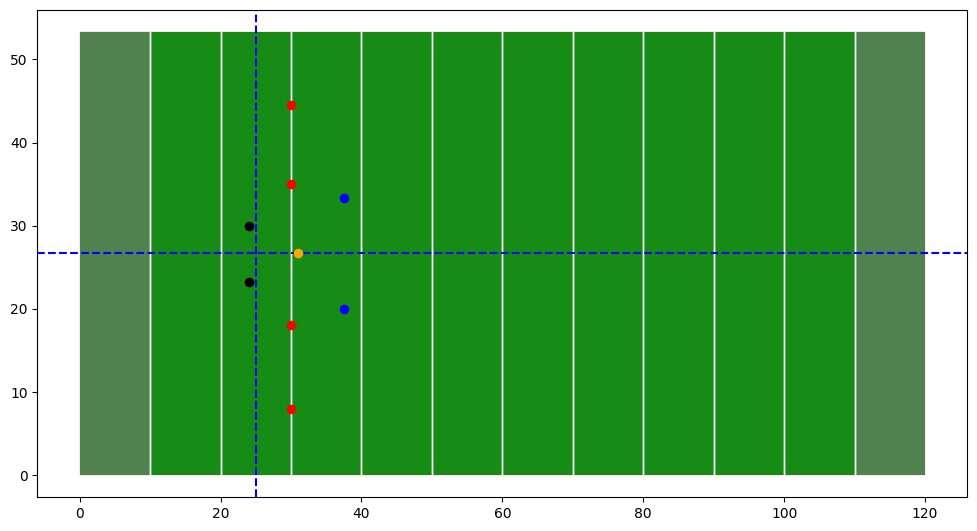

In [ ]:
# charting canvas for position -- subject to change!

fig, ax = create_football_field()
create_football_field(ax)

ax.axvline(x=25, color='blue', linestyle='--') # line of scrimmage
ax.axhline(y=26.66, color='blue', linestyle='--') # middle alignment

ax.scatter(30, 8, color='red', s=35) # lower outside corner
ax.scatter(30, 44.5, color='red', s=35) # upper outside corner
ax.scatter(30, 35, color='red', s=35) # upper slot
ax.scatter(30, 18, color='red', s=35) # lower slot
ax.scatter(31, 26.66, color='orange', s=35,zorder=5,label='MLB') # middle line backer
ax.scatter(37.5, 33.3, color='blue', s=35) # lower deep safety
ax.scatter(37.5, 20, color='blue', s=35) # upper deep safety

# charting o line for reference
ax.scatter(24, 23.2, color='black', s=35) # left tackle
ax.scatter(24, 30, color='black', s=35) # right tackle

## (Non-Motion) Starting Points / Alignment

In [ ]:
positions = [
      {'x': 30, 'y': 8, 'label': 'lower outside corner'},
      {'x': 30, 'y': 44.5, 'label': 'upper outside corner'},
      {'x': 30, 'y': 35, 'label': 'upper slot'},
      {'x': 30, 'y': 18, 'label': 'lower slot'},
      {'x': 31, 'y': 26.66, 'label': 'middle linebacker (MLB)'},
      {'x': 37, 'y': 33.3, 'label': 'lower deep safety'},
      {'x': 37, 'y': 20, 'label': 'upper deep safety'}
  ]

positions_dict = {p['label']: p for p in positions}

In [ ]:
def get_closest_position(x_clean, y_clean, positions):

  distances = []
  for pos in positions:
      distance = np.sqrt((x_clean - pos['x'])**2 + (y_clean - pos['y'])**2)
      distances.append(distance)

  min_index = np.argmin(distances)
  closest_label = positions[min_index]['label']

  return closest_label

In [ ]:
#non_motions_ids = list(set(non_motion_tells['uniqueId']))

tells_ids = list(set(players_tells['uniqueId']))

for uid in tells_ids:

  play = players_tells[players_tells['uniqueId'] == uid]

  first_frame = play.sort_values(by='frameId',ascending=True).head(1)['frameId'].iloc[0]
  tell_player = play['tellPlayerName'].iloc[0]

  tell_starting_point = play[(play['displayName'] == tell_player) & (play['frameId'] == first_frame)]

  try:

    x,y = tell_starting_point['x_clean'].iloc[0], tell_starting_point['y_clean'].iloc[0]

    starting_align = get_closest_position(x, y, positions)

    players_tells.loc[players_tells['uniqueId'] == uid, 'starting_align'] = starting_align

  except IndexError:

    print(f"Error on {uid}")

    continue

Error on 2022091809_1787


In [ ]:
from scipy.interpolate import splprep, splev

def smooth_mean_trajectory(x_paths, y_paths, s=0.5, num_interp_points=50):
  """
  Given a list of x_paths and y_paths (each a 1D array of points),
  compute the mean path and return a spline-smoothed curve.
  """
  # Ensure all paths have the same number of points by interpolation
  standardized_x = []
  standardized_y = []

  for x_full, y_full in zip(x_paths, y_paths):
      t = np.linspace(0, 1, len(x_full))
      t_new = np.linspace(0, 1, num_interp_points)
      x_resampled = np.interp(t_new, t, x_full)
      y_resampled = np.interp(t_new, t, y_full)
      standardized_x.append(x_resampled)
      standardized_y.append(y_resampled)

  mean_x = np.mean(standardized_x, axis=0)
  mean_y = np.mean(standardized_y, axis=0)

  tck, u = splprep([mean_x, mean_y], s=s)
  unew = np.linspace(0, 1, 200)  # 200 points for a smooth curve
  x_smooth, y_smooth = splev(unew, tck)

  return x_smooth, y_smooth

In [ ]:
def team_tell_player_norm(player_data, coverage_tell, team, alpha=True):

  # consider adding:

  ### --- red/blue on the dots based on the sample size (blue, only once were they a "tell"... red is a "hot" tell)
  ### ---

  if coverage_tell == "zone":
      player_data = player_data[player_data['moves_to_zone'] == 1]
  elif coverage_tell == "man":
      player_data = player_data[player_data['moves_to_man'] == 1]

  unique_ids = player_data['uniqueId'].unique()

  player_data = player_data.sort_values('frameId')

  fig, ax = create_football_field()
  create_football_field(ax)

  ax.axvline(x=25, color='blue', linestyle='--') # line of scrimmage
  ax.scatter(24, 23.2, color='black', s=35) # left tackle
  ax.scatter(24, 24.8, color='black', s=35) # left tackle
  ax.scatter(24, 26.5, color='black', s=35) # center
  ax.scatter(24, 28, color='black', s=35) # left tackle
  ax.scatter(24, 30, color='black', s=35) # right tackle
  ax.scatter(19, 26.5, color='black', s=35) # qb

  for uid in unique_ids:

    # right now - iterating by each uniqueid... need to group each iteration to the poistion & then average...

    x_paths = []
    y_paths = []

    play_df = player_data[player_data['uniqueId'] == uid]

    # print(play_df)

    tell_player = play_df['tellPlayerName'].iloc[0]
    starting_align_label = play_df['starting_align'].iloc[0]

    anchor_pos = positions_dict[starting_align_label]
    target_x = anchor_pos['x']
    target_y = anchor_pos['y']

    tell_player_data = play_df[play_df['displayName'] == tell_player]
    x_full = tell_player_data['x_clean'].values
    y_full = tell_player_data['y_clean'].values

    initial_x, initial_y = x_full[0], y_full[0]

    x_shift, y_shift = target_x - initial_x, target_y - initial_y

    x_full_shifted = x_full + x_shift
    y_full_shifted = y_full + y_shift

    x_paths.append(x_full_shifted)
    y_paths.append(y_full_shifted)

    ax.plot(x_full_shifted, y_full_shifted, color='black', linewidth=1)
    ax.scatter(x_full_shifted[0], y_full_shifted[0], color='red', s=20, zorder=5)

    #x_smooth, y_smooth = smooth_mean_trajectory(x_paths, y_paths, s=1.0)  # adjust s for smoothing level
    #ax.plot(x_smooth, y_smooth, color='white', linewidth=2, linestyle='-', zorder=10)
    #ax.plot(x_smooth, y_smooth, color='blue', linewidth=1.5, zorder=11)  # slight offset for a highlight effect

  ax.set_title(f"{team} {coverage_tell.capitalize()} Tells")
  plt.show()

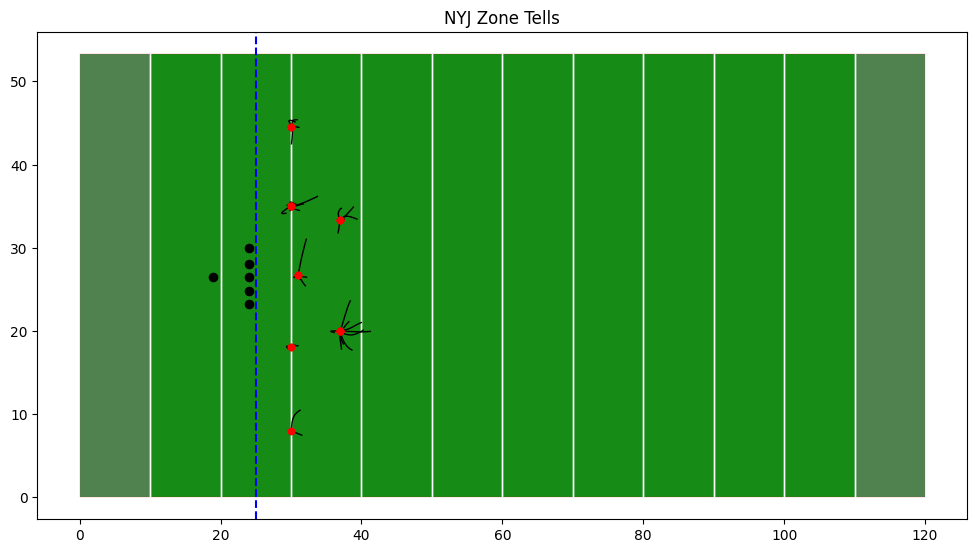

In [ ]:
non_motion_tells = players_tells[(players_tells['motionSinceLineset'] == 0) & (players_tells['shiftSinceLineset'] == 0)]

non_motions_ids = list(set(non_motion_tells['uniqueId']))

team_list = list(set(non_motion_tells['defensiveTeam']))
team = random.choice(team_list)
team = "NYJ"

team_data = non_motion_tells[non_motion_tells['defensiveTeam'] == team]
coverage_tell = "zone"

team_tell_player_norm(team_data, coverage_tell, team, alpha=False)

Vis to explore:

*   Individual player
*   Team level
* League level
* Scheme level (different DC trees)
* A network between these "nodes" - intensity of connection weighed by sample & probability given

In [ ]:
def team_tell_player_norm_avg(player_data, coverage_tell, team, alpha=True):

  # consider adding:

  ### --- red/blue on the dots based on the sample size (blue, only once were they a "tell"... red is a "hot" tell)
  ### ---

  if coverage_tell == "zone":
      player_data = player_data[player_data['moves_to_zone'] == 1]
  elif coverage_tell == "man":
      player_data = player_data[player_data['moves_to_man'] == 1]

  # unique_ids = player_data['uniqueId'].unique()

  player_data = player_data.sort_values('frameId')

  grouped = player_data.groupby('starting_align')

  fig, ax = create_football_field()
  create_football_field(ax)

  offense_color = "gray"

  ax.axvline(x=25, color="blue", linestyle='--') # line of scrimmage
  ax.scatter(24, 23.2, color=offense_color, s=35, edgecolor='white',linewidths=0.25) # left tackle
  ax.scatter(24, 24.8, color=offense_color, s=35, edgecolor='white',linewidths=0.25) # left tackle
  ax.scatter(24, 26.5, color=offense_color, s=35, edgecolor='white',linewidths=0.25) # center
  ax.scatter(24, 28, color=offense_color, s=35, edgecolor='white',linewidths=0.25) # left tackle
  ax.scatter(24, 30, color=offense_color, s=35, edgecolor='white',linewidths=0.25) # right tackle
  ax.scatter(19, 26.5, color=offense_color, s=35, edgecolor='white',linewidths=0.25) # qb

  for align_label, group_df in grouped:

    x_paths = []
    y_paths = []

    anchor_pos = positions_dict[align_label]
    target_x = anchor_pos['x']
    target_y = anchor_pos['y']

    for uid in group_df['uniqueId'].unique():

      play_df = group_df[group_df['uniqueId'] == uid]

      tell_player = play_df['tellPlayerName'].iloc[0]
      tell_player_data = play_df[play_df['displayName'] == tell_player]

      x_full = tell_player_data['x_clean'].values
      y_full = tell_player_data['y_clean'].values

      initial_x, initial_y = x_full[0], y_full[0]

      x_shift = target_x - initial_x
      y_shift = target_y - initial_y

      x_full_shifted = x_full + x_shift
      y_full_shifted = y_full + y_shift

      x_paths.append(x_full_shifted)
      y_paths.append(y_full_shifted)

      ax.plot(x_full_shifted, y_full_shifted, color='black', linewidth=1, alpha=0.6)
      ax.scatter(x_full_shifted[0], y_full_shifted[0], color='white', s=25, zorder=5,edgecolor='gray',linewidths=0.25)

    x_smooth, y_smooth = smooth_mean_trajectory(x_paths, y_paths, s=1.0)
    ax.plot(x_smooth, y_smooth, color='#BF0000', linewidth=1.5, zorder=11)

  ax.set_title(f"{team} {coverage_tell.capitalize()} Tells")
  plt.show()

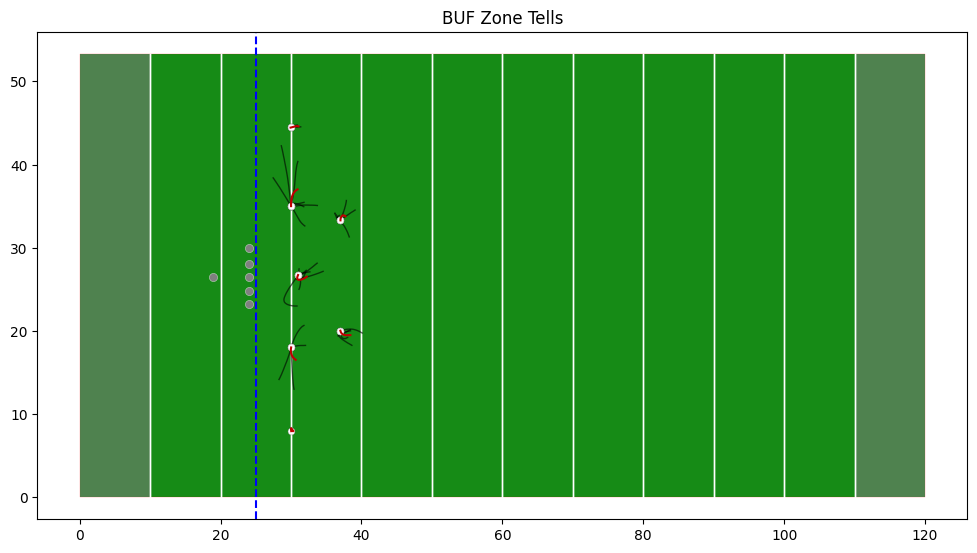

In [ ]:
team_list = list(set(non_motion_tells['defensiveTeam']))
team = random.choice(team_list)
team = "BUF" # - sort MIA, that's a good find, NYJ, BUF

team_data = non_motion_tells[non_motion_tells['defensiveTeam'] == team]
coverage_tell = "zone"

team_tell_player_norm_avg(team_data, coverage_tell, team, alpha=False)

## Motion Charting


**Classify / label type of motion by position:**

*   WR: fly/jet motion (if WR crosses QB), glide/in (if WR stays outside), caveat for return
*   RB: exit / flare / slide (exits the tackle box & starts in backfield) -- are you starting your motion in the tackle box? othewrise label as WR
* TE: over/cross (motions towards center), glide/exit (motions towards sideline)


From start of motion to end of tell?


In [ ]:
# filtering for motions tells
motion_tells = players_tells[players_tells['motionSinceLineset'] == 1]

# gathering motion tell ids, grabbing info from player_play
motion_ids = list(set(motion_tells['uniqueId']))

player_play['uniqueId'] = player_play['gameId'].astype(str) + "_" + player_play['playId'].astype(str)
player_play_motion = player_play[player_play['uniqueId'].isin(motion_ids)]

# gathering the exact player who motioned
motions = player_play_motion[player_play_motion['motionSinceLineset'] == 1]

motion_player = motions[['uniqueId', 'nflId']]
motion_player.rename(columns={'nflId': 'motionId'}, inplace=True)

motion_tells = motion_tells.merge(motion_player,on='uniqueId',how='left')
motion_tells = motion_tells.dropna(subset='motionId')

# adding position of motioning player
positions = players[['nflId', 'position']]
positions.rename(columns={'nflId': 'motionId', 'position': 'motionPos'}, inplace=True)

motion_tells = motion_tells.merge(positions, on='motionId',how='left')

In [ ]:
# filtering out all false motions -- where the motion happened before the actual tell

motion_tells['speed_mph'] = motion_tells['s'] * 2.045 # ~8mph threshold
motion_players = motion_tells[motion_tells['nflId'] == motion_tells['motionId']]

valid_unique_ids = motion_players[motion_players['speed_mph'] >= 8]['uniqueId'].unique()
real_motion_tells = motion_tells[motion_tells['uniqueId'].isin(valid_unique_ids)]

new_non_motion_tells = motion_tells[~motion_tells['uniqueId'].isin(valid_unique_ids)]

In [ ]:
new_non_motion_tells.shape[0] # add back into non_motion_tells!

236218

In [ ]:
# for wr - is velo vector pointed towards qb / los?
wr_motion = real_motion_tells[real_motion_tells['motionPos'] == "WR"]
wr_in_motion = wr_motion[wr_motion['nflId'] == wr_motion['motionId']]

def get_starting_half(group):
  first_y = group['y_clean'].iloc[0]
  half = 'lower' if first_y < 26.66 else 'top'
  return half

def y_increase_decrease(group):
  group = group.sort_values(by='frameId')
  first_y = group['y_clean'].iloc[0]
  last_y = group['y_clean'].iloc[-1]
  if last_y > first_y:
    movement = 'increasing'
  else:
    movement = 'decreasing'
  return movement

movement_mapping = wr_in_motion.groupby('uniqueId').apply(y_increase_decrease).to_dict()
starting_half_mapping = wr_in_motion.groupby('uniqueId').apply(get_starting_half).to_dict()

wr_in_motion['starting_half'] = wr_in_motion['uniqueId'].map(starting_half_mapping)
wr_in_motion['movement_motion'] = wr_in_motion['uniqueId'].map(movement_mapping)

# logic pattern:

# -- if wr starts in the lower half & y_clean increases, motioning up (jet)
# -- if wr starts in the lower half & y_clean decreases, motions out (glide)

# -- if wr starts in the upper half & y_clean decreases, motions down (jet) -- 2022101606_2791
# -- if wr starts in the upper half & y_clean increases, motions out (glide) --

def classify_wr_motion(row):

  if row['starting_half'] == 'lower':

    if row['movement_motion'] == 'increasing':
        return 'Jet/Fly'
    elif row['movement_motion'] == 'decreasing':
        return 'Glide'

  elif row['starting_half'] == 'top':

    if row['movement_motion'] == 'decreasing':
        return 'Jet/Fly'
    elif row['movement_motion'] == 'increasing':
        return 'Glide'

  return 'unknown'

wr_in_motion['wr_motion_class'] = wr_in_motion.apply(classify_wr_motion, axis=1)
wr_motion_class = wr_in_motion[['uniqueId', 'wr_motion_class']].drop_duplicates(subset='uniqueId')

wr_motion = wr_motion.merge(wr_motion_class, on='uniqueId')

<ipython-input-57-9ea269d8bbe0>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  movement_mapping = wr_in_motion.groupby('uniqueId').apply(y_increase_decrease).to_dict()
<ipython-input-57-9ea269d8bbe0>:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  starting_half_mapping = wr_in_motion.groupby('uniqueId').apply(get_starting_half).to_dict()


## Influence Functions

In [ ]:
desc_motion_start = wr_in_motion[['uniqueId', 'starting_half', 'movement_motion']]

wr_motion = wr_motion.merge(desc_motion_start, on='uniqueId')

In [ ]:
wr_motion['movement_motion'].value_counts()

,count
movement_motion,
decreasing,1216931
increasing,1169640


In [ ]:
fly_wr_motions_ids = list(set(wr_motion[wr_motion['wr_motion_class'] == "Jet/Fly"]['uniqueId']))
fly_lower = wr_motion[(wr_motion['starting_half'] == 'lower') & (wr_motion['movement_motion'] == 'increasing')]

In [ ]:
from scipy.stats import multivariate_normal

def influence_function(position, locations, velocity, radius=5):

  mu = position + 0.5 * velocity # Note: assuming half a second in the future

  s_ratio = (velocity[0]**2 + velocity[1]**2)/15**2 # Note: 15 is a hyperparam, eyeballed (non-exact)... can optimize

  theta = np.arctan(velocity[1]/(velocity[0]+1e-7)) # Note: Adding epsilon so no div by 0

  R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
  R_inv = np.array([[np.cos(theta), np.sin(theta)],[-np.sin(theta), np.cos(theta)]])

  Ri = 3.5 # Note: Hyperparam - set as 10 based on eyeball from vis -- "feels" right

  S = np.array([[(1 + s_ratio)*Ri/2, 0],[0, (1-s_ratio)*Ri/2]])

  Cov = np.matmul(np.matmul(np.matmul(R, S), S), R_inv)

  new_gaussian = multivariate_normal(mu, Cov)
  out = new_gaussian.pdf(locations)
  out /= new_gaussian.pdf(position)

  return out

In [ ]:
def control_df(control_array):

  #print(control_array)

  control_reshaped = control_array.reshape(1200, 530)
  control_120_53 = control_reshaped.reshape(120, 10, 53, 10).sum(axis=(1, 3))
  control_df = (pd.DataFrame(control_120_53))

  return control_df

In [ ]:
## calling functions
x, y = np.mgrid[0:120:0.1, 0:53:0.1]
locations = np.concatenate([x.reshape(-1, 1), y.reshape(-1, 1)], axis=1)

In [ ]:
def essentials_frame_field_control(uid, frame_num, wr_motion):

  #fig, ax = create_football_field()

  #print(type(uid))

  defense_control = 0

  frame = wr_motion[(wr_motion['uniqueId'] == uid) & (wr_motion['frameId'] == frame_num)]

  #print(frame)

  frame['v_x'] = frame['s_clean'] * np.cos(np.radians(frame['dir_clean']))
  frame['v_y'] = frame['s_clean'] * np.sin(np.radians(frame['dir_clean']))

  frame = frame[frame['defense'] == 1]

  for index, row in frame.iterrows():

    position = np.array([row['x_clean'], row['y_clean']])
    velocity = np.array([row['v_x'], row['v_y']])

    influence = influence_function(position, locations, velocity, radius=10)

    defense_control += influence

  return control_df(defense_control)

In [ ]:
def defense_control_difference(uniqueId, wr_motion):

  play_data = wr_motion[wr_motion['uniqueId'] == uniqueId]
  min_frame = int(play_data['frameId'].min())
  max_frame = int(play_data['frameId'].max())

  #print(play_data)
  #print(max_frame)

  ## need to put the proper frames here...

  starting_influence = essentials_frame_field_control(uniqueId, min_frame, wr_motion)
  ending_influence = essentials_frame_field_control(uniqueId, max_frame, wr_motion)

  masked_difference_control = plot_defense_control_difference_heatmap(starting_influence, ending_influence, plot=False)

  return masked_difference_control

In [ ]:
def plot_defense_control_difference_heatmap(min_frame_influence, max_frame_influence,plot=False):

  difference_control = max_frame_influence - min_frame_influence

  x, y = np.mgrid[0:120:1, 0:53:1]
  masked_difference_control = np.ma.masked_where(np.abs(difference_control) <= 0.1, difference_control)

  if plot:

    fig, ax = create_football_field()
    heatmap = ax.contourf(x, y, masked_difference_control, levels=10, cmap="coolwarm", alpha=0.85)
    fig.colorbar(heatmap, ax=ax, label="Change in Defense Control")

    plt.show()

  return masked_difference_control

In [ ]:
def compile_all_heatmaps(wr_motion, unique_ids):

  total_difference_control = None

  for ex_id in unique_ids:
      play_data = wr_motion[wr_motion['uniqueId'] == ex_id]
      difference = defense_control_difference(ex_id, wr_motion)

      if total_difference_control is None:
          total_difference_control = difference.copy()
      else:
          total_difference_control += difference  # Aggregate heatmaps

  return total_difference_control

def plot_compiled_heatmap(compiled_control, unique_ids, wr_motion):

    x, y = np.mgrid[0:120:1, 0:53:1]
    masked_control = np.ma.masked_where(np.abs(compiled_control) <= 0.0000001, compiled_control)

    fig, ax = create_football_field()
    heatmap = ax.contourf(x, y, masked_control, levels=10, cmap="coolwarm", alpha=0.85)
    fig.colorbar(heatmap, ax=ax, label="Aggregate Change in Defense Control")

    offense_color = "white"
    ax.axvline(x=25, color="blue", linestyle='--') # line of scrimmage
    ax.scatter(24, 23.2, color=offense_color, s=35, edgecolor='black',linewidths=0.25) # left tackle
    ax.scatter(24, 24.8, color=offense_color, s=35, edgecolor='black',linewidths=0.25) # left tackle
    ax.scatter(24, 26.5, color=offense_color, s=35, edgecolor='black',linewidths=0.25) # center
    ax.scatter(24, 28, color=offense_color, s=35, edgecolor='black',linewidths=0.25) # left tackle
    ax.scatter(24, 30, color=offense_color, s=35, edgecolor='black',linewidths=0.25) # right tackle
    ax.scatter(19, 26.5, color=offense_color, s=35, edgecolor='black',linewidths=0.25) # qb

    for ex_id in unique_ids:

      play_df = wr_motion[wr_motion['uniqueId'] == ex_id]

      play_df = play_df.sort_values(by='frameId', ascending=True)

      id_motioner = play_df['motionId'].iloc[0]  # Assuming column 'motionPlayerName'

      motion_player_data = play_df[play_df['nflId'] == id_motioner]

      motion_player_data = motion_player_data.sort_values(by='frameId', ascending=True)
      lowest_frame_row = motion_player_data[motion_player_data['frameId'] == motion_player_data['frameId'].min()]

      ax.scatter(lowest_frame_row['x_clean'], lowest_frame_row['y_clean'], color='red', s=20, zorder=5)

      x_full = motion_player_data['x_clean'].values
      y_full = motion_player_data['y_clean'].values

      ax.plot(x_full, y_full, color='black', linewidth=2, linestyle='-', alpha=0.9, zorder=11)

    ax.set_title("Aggregate Change in Defense Control with Motion Paths")
    plt.show()


    plt.show()

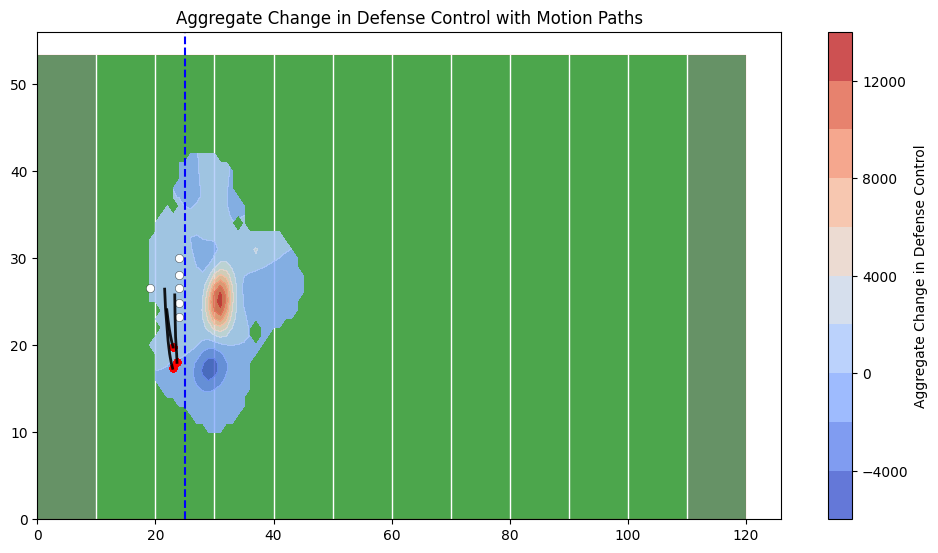

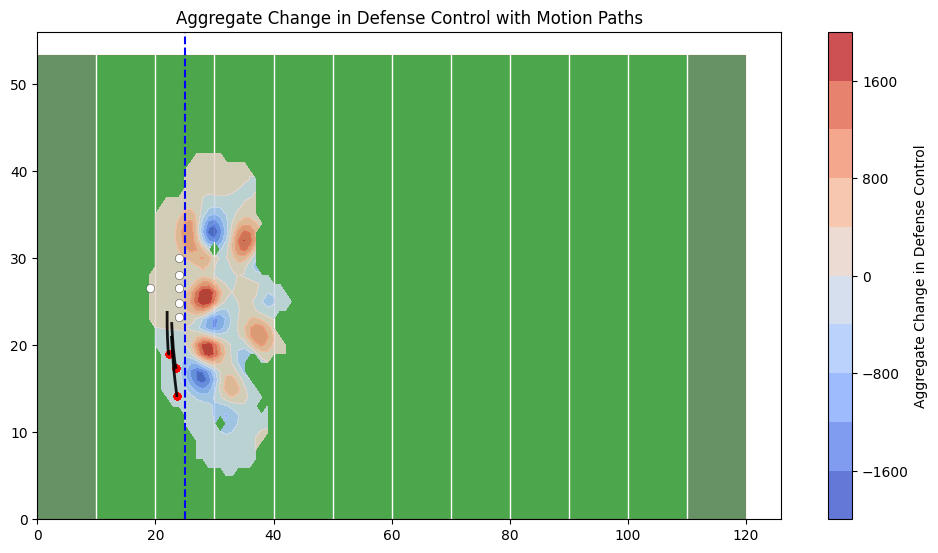

In [ ]:
team_id = "CAR"

fly_lower_team = fly_lower[fly_lower['defensiveTeam'] == team_id]
fly_lower_man = fly_lower_team[fly_lower_team['pff_manZone'] == 1]
fly_lower_zone = fly_lower_team[fly_lower_team['pff_manZone'] == 0]

unique_ids_man = fly_lower_man['uniqueId'].unique()
unique_ids_zone = fly_lower_zone['uniqueId'].unique()

# unique_ids = unique_ids[:4]
compiled_control_man = compile_all_heatmaps(wr_motion, unique_ids_man)
compiled_control_zone = compile_all_heatmaps(wr_motion, unique_ids_zone)

plot_compiled_heatmap(compiled_control_man, unique_ids_man, wr_motion)
plot_compiled_heatmap(compiled_control_zone, unique_ids_zone, wr_motion)